In [63]:
# 导入数据分析及可视化常用数据库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# 设置sns样式
# 样式控制：axes_style() and set_style()
# 有5个seaborn的主题，适用于不同的应用和人群偏好：
# darkgrid 黑色网格（默认）
# whitegrid 白色网格
# dark 黑色背景
# white 白色背景
# ticks 应该是四周都有刻度线的白背景
sns.set(style='white',context='notebook',palette='muted')

In [64]:
# 读取训练及测试数据,保存为DataFrame格式
data_train = pd.read_csv('../data/titanic/train.csv')
data_test = pd.read_csv('../data/titanic/test.csv')
# 分别查看实验数据集和预测数据集数据
print('训练数据大小:',data_train.shape)
print('预测数据大小:',data_test.shape)
# 训练数据891组，测试数据418组，测试数据缺少列为结果列

训练数据大小: (891, 12)
预测数据大小: (418, 11)


In [65]:
# 将实验数据和预测数据合并,便于后续对所有特征值进行同步处理
# 显示训练数据前10行，观察数据格式，变量名称，对数据有一个总体上的了解
data_all = data_train.append(data_test, ignore_index=True)
data_all.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [66]:
# 数值特征统计
# 了解数据总体分布趋势,均值\标准差\极值\四分位数等信息
data_all.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


In [67]:
# 数值特征统计
# 统计特征值类型及缺失值
# Age，Cabin，Embarked，Fare特征存在缺失值
# Age缺失数据较多，可以通过机器学习预测,或采用均值加标准差随机填充
# Cabin缺失一半以上数据，且无规律难以预测，可以建立新标签-Unknown
# Embarked仅缺失2组特征值，可采用众数填充
# Fare缺失一组特征值，该特征主要受船舱等级、登陆港口影响，可根据对应特征的Fare平均值填充
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [68]:
# 数据清理,对缺失数据进行填充
# Fare,票价,在测试数据中,三等舱,港口为S
data_all[data_all['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [69]:
# 对缺失数据采用三等舱\登船港口S乘客平均票价填充
data_all['Fare'].fillna(data_all[(data_all['Pclass']==3)&(data_all['Embarked']=='S')]['Fare'].mean(), inplace=True)

In [70]:
# Cabin,船舱号,缺失一半以上数据,建立新标签'Unknown'进行填充
data_all['Cabin'].fillna('U', inplace=True)

In [71]:
# Embarked,登船港口,缺失一个数据,可以采用众数填充
data_all['Embarked'].fillna(data_all['Embarked'].mode()[0], inplace=True)

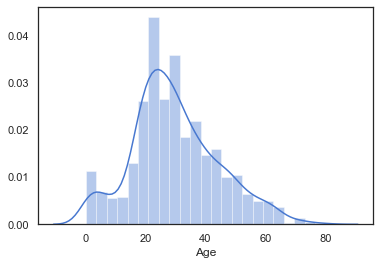

In [72]:
# Age,年龄缺失300组,主要如下图所示,近似正态分布
sns.distplot(data_all['Age'])

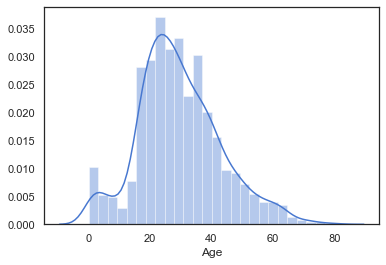

In [73]:
# 统计年龄分布参数,均值,标准差,缺失个数
age_avg, age_std = data_all['Age'].mean(), data_all['Age'].std()
age_null_count = data_all['Age'].isnull().sum()

# 3种方法进行缺失值的填充,高斯正态分布生成随机数,随机分布,中位数
# 1 高斯正态分布
# age_null_random_list = abs(np.random.normal(age_avg, age_std, size=age_null_count))
# data_all['Age'][np.isnan(data_all['Age'])] = age_null_random_list
# 2 random随机分布
age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
data_all['Age'][np.isnan(data_all['Age'])] = age_null_random_list
# 3 中位数填充
# data_all['Age'].fillna(data_all['Age'].median(), inplace=True)
# 填充后重新绘图对比
sns.distplot(data_all['Age'])

In [74]:
# 所有缺失数据补充完成
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [75]:
data_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


In [76]:
# 特征工程,基于现有特征建立新的特征
#　Name,构造新特征Title
data_all['Title']=data_all['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
title_Dict = {}
title_Dict.update(dict.fromkeys(["Capt", "Col", "Major", "Dr", "Rev"], "Officer"))
title_Dict.update(dict.fromkeys(["Don", "Sir", "the Countess", "Dona", "Lady"], "Royalty"))
title_Dict.update(dict.fromkeys(["Mme", "Ms", "Mrs"], "Mrs"))
title_Dict.update(dict.fromkeys(["Mlle", "Miss"], "Miss"))
title_Dict.update(dict.fromkeys(["Mr"], "Mr"))
title_Dict.update(dict.fromkeys(["Master", "Jonkheer"], "Master"))
data_all["Title"] = data_all["Title"].map(title_Dict)    
data_all['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

In [77]:
# Age,分仓,提升该特征值容错性
# 特征编码
data_all['AgeBin'] = pd.factorize(pd.cut(data_all['Age'], 5))[0]

In [78]:
# Fare,针对可能存在的团体票,家庭票情况,统计相同票号的情况
TickCountDict={}
TickCountDict=data_all['Ticket'].value_counts()
#将同票号乘客数量数据并入数据集中
data_all['TickCot']=data_all['Ticket'].map(TickCountDict)
data_all['Fare'] = data_all['Fare'] / data_all['TickCot']

In [79]:
# Fare,票价/人数，分仓
data_all['Fare'] = data_all['Fare'] / data_all['TickCot']
data_all['FareBin'] = pd.factorize(pd.qcut(data_all['Fare'], 6))[0]

In [80]:
# 创建家庭成员数量及是否孤身一人特征值
data_all['FamilySize'] = data_all['SibSp'] + data_all['Parch'] + 1
data_all['IsAlone'] = 1 #initialize to yes/1 is alone
data_all['IsAlone'].loc[data_all['FamilySize'] > 1] = 0

In [81]:
# Cabin,提取舱号字母
data_all['Cabin'] = data_all['Cabin'].apply(lambda x:str(x)[0])

In [82]:
# 重新检查数据
data_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBin,TickCot,FareBin,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,U,S,Mr,0,1,0,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,17.820825,C,C,Mrs,1,2,1,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,U,S,Miss,0,1,2,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,13.275000,C,S,Mrs,1,2,3,2,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050000,U,S,Mr,1,1,2,1,1


In [104]:
# 标签编码
data_code = data_all.copy()
data_code.drop(['Name','Age','SibSp','Parch','Fare','Ticket'], axis=1, inplace=True)
data_code['Sex'] = pd.factorize(data_code['Sex'])[0]
data_code['Embarked'] = pd.factorize(data_code['Embarked'])[0]
data_code['Title'] = pd.factorize(data_code['Title'])[0]
data_code['Cabin'] = pd.factorize(data_code['Cabin'])[0]
data_code.to_excel(r'../data/titanic/data_factorized.xlsx')
data_code.head()

,PassengerId,Survived,Pclass,Sex,Cabin,Embarked,Title,AgeBin,TickCot,FareBin,FamilySize,IsAlone
0,1,0.0,3,0,0,0,0,0,1,0,2,0
1,2,1.0,1,1,1,1,1,1,2,1,2,0
2,3,1.0,3,1,0,0,2,0,1,2,1,1
3,4,1.0,1,1,1,0,1,1,2,3,2,0
4,5,0.0,3,0,0,0,0,1,1,2,1,1


In [84]:
# one-hot编码
data_dummy = data_all.copy()
data_dummy.drop(['Name','Age','SibSp','Parch','Fare','Ticket'], axis=1, inplace=True)
data_dummy = pd.get_dummies(data_dummy)
FamilySize_dummy = pd.get_dummies(data_dummy['FamilySize'], prefix='FamilySize')
AgeBin_dummy = pd.get_dummies(data_dummy['AgeBin'], prefix='AgeBin')
Pclass_dummy = pd.get_dummies(data_dummy['Pclass'], prefix='Pclass')
TickCot_dummy = pd.get_dummies(data_dummy['TickCot'], prefix='TickCot')
FareBin_dummy = pd.get_dummies(data_dummy['FareBin'], prefix='FareBin')
data_dummy.drop(['Pclass','AgeBin','TickCot','FareBin','FamilySize'], axis=1, inplace=True)
data_dummy = pd.concat([data_dummy, AgeBin_dummy, Pclass_dummy, FareBin_dummy], axis=1)
data_dummy.to_excel(r'../data/titanic/data_dummy.xlsx')
data_dummy.head()

,PassengerId,Survived,IsAlone,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,AgeBin_4,Pclass_1,Pclass_2,Pclass_3,FareBin_0,FareBin_1,FareBin_2,FareBin_3,FareBin_4,FareBin_5
0,1,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,2,1.0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,3,1.0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,4,1.0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5,0.0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


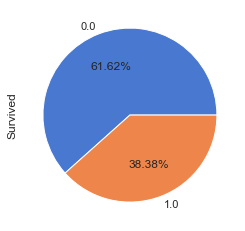

In [85]:
# 可视化分析所有特征值
# 训练数据总体存活的比例: 存活率38.38%
data_all['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

In [86]:
# 依次分析所有特征值
# Pclass,船舱等级特征无缺失值,类型为int64,3等舱乘客最多
data_all['Pclass'].value_counts(sort=False, ascending=True)

1    323
2    277
3    709
Name: Pclass, dtype: int64

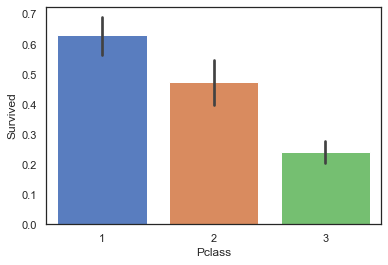

In [87]:
# Pclass,可视化显示对存活率的影响
# 具有很明显的分布规律,船舱等级越高,存活概率越高
sns.barplot(data=data_all,x='Pclass',y='Survived')

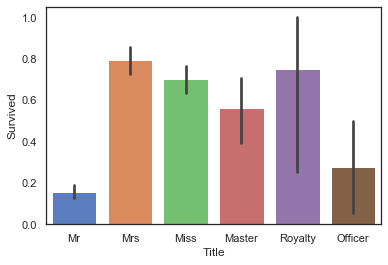

In [88]:
# Title与Survived之间关系: Mr存活率最低
sns.barplot(data=data_all,x='Title',y='Survived')

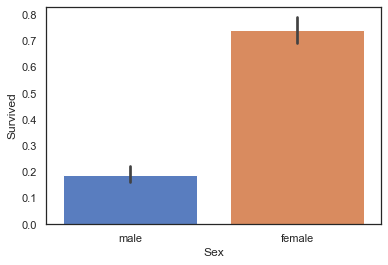

In [89]:
# Sex与Survived：女性的生存率远高于男性
sns.barplot(data=data_all,x='Sex',y='Survived')

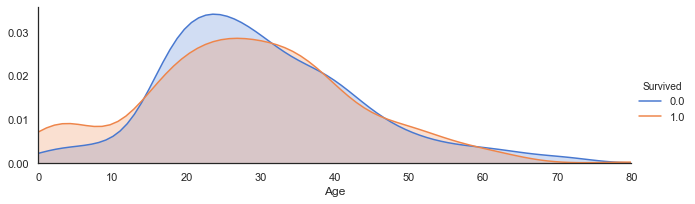

In [90]:
# Age与Survived：当乘客年龄段在0-10岁期间时生存率会较高,存活概率大于死亡概率

#创建坐标轴
ageFacet=sns.FacetGrid(data_all,hue='Survived',aspect=3)
#作图，选择图形类型
ageFacet.map(sns.kdeplot,'Age',shade=True)
#其他信息：坐标轴范围、标签等
ageFacet.set(xlim=(0,data_all['Age'].max()))
ageFacet.add_legend()

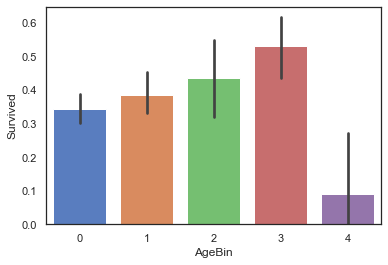

In [91]:
# AgeBin与Survived
sns.barplot(data=data_all,x='AgeBin',y='Survived')

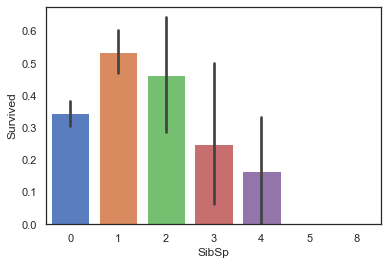

In [92]:
# SibSp与Survived：当乘客同行的同辈数量适中时生存率较高
sns.barplot(data=data_all,x='SibSp',y='Survived')

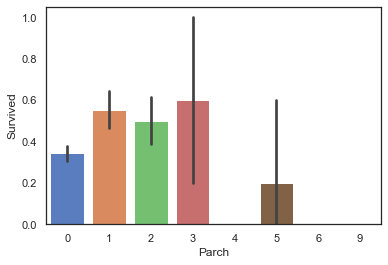

In [93]:
# Parch与Survived：当乘客同行的父母及子女数量适中时，生存率较高
sns.barplot(data=data_all,x='Parch',y='Survived')

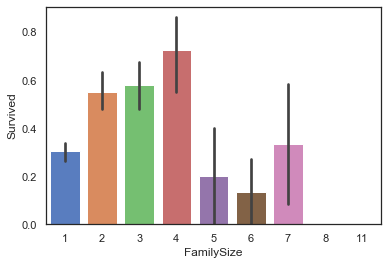

In [94]:
# SibSp与Survived：独自一人情况下存活率较低
sns.barplot(data=data_all,x='FamilySize',y='Survived')

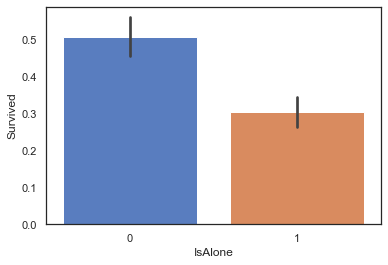

In [95]:
# SibSp与Survived：独自一人情况下存活率较低
sns.barplot(data=data_all,x='IsAlone',y='Survived')

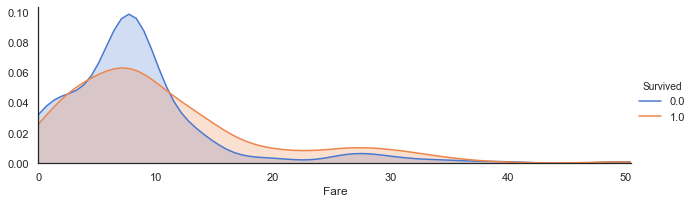

In [96]:
# Fare与Survived：票价越低,存活比率越低
#创建坐标轴
ageFacet=sns.FacetGrid(data_all,hue='Survived',aspect=3)
#作图，选择图形类型
ageFacet.map(sns.kdeplot,'Fare',shade=True)
#其他信息：坐标轴范围、标签等
ageFacet.set(xlim=(0,data_all['Fare'].max()))
ageFacet.add_legend()

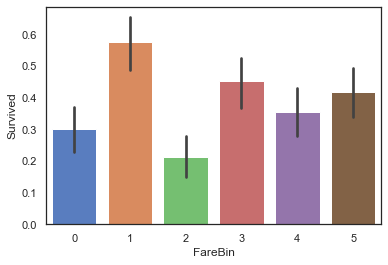

In [97]:
# FareBIn与Survived
sns.barplot(data=data_all,x='FareBin',y='Survived')

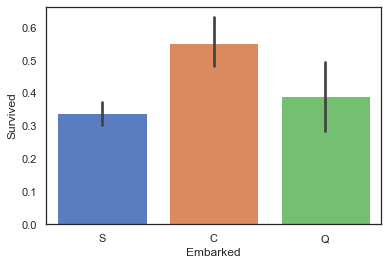

In [98]:
# Embarked与Survived
sns.barplot(data=data_all,x='Embarked',y='Survived')

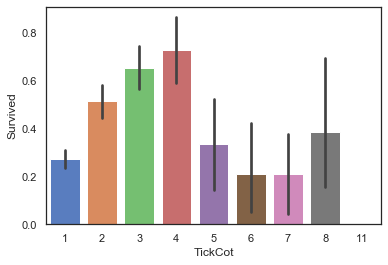

In [99]:
# Title与Survived
sns.barplot(data=data_all,x='TickCot',y='Survived')

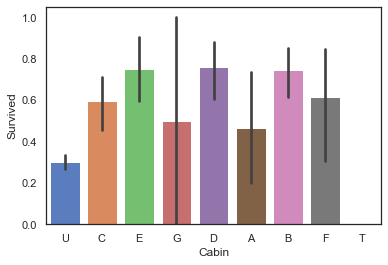

In [100]:
# 船舱号与存活率关系
sns.barplot(data=data_all,x='Cabin',y='Survived')

In [101]:
data_code.head()

,Survived,Pclass,Sex,Cabin,Embarked,Title,AgeBin,TickCot,FareBin,FamilySize,IsAlone
0,0.0,3,0,0,0,0,0,1,0,2,0
1,1.0,1,1,1,1,1,1,2,1,2,0
2,1.0,3,1,0,0,2,0,1,2,1,1
3,1.0,1,1,1,0,1,1,2,3,2,0
4,0.0,3,0,0,0,0,1,1,2,1,1


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

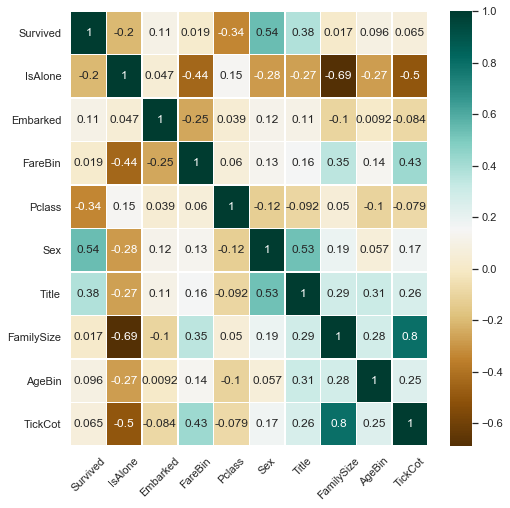

In [102]:
#热力图,查看Survived与其他特征间相关性大小
plt.figure(figsize=(8,8))
sns.heatmap(data_code[
    ['Survived','IsAlone','Embarked','FareBin','Pclass','Sex','Title','FamilySize','AgeBin','TickCot']
    ].corr(),cmap='BrBG',annot=True,linewidths=.5)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

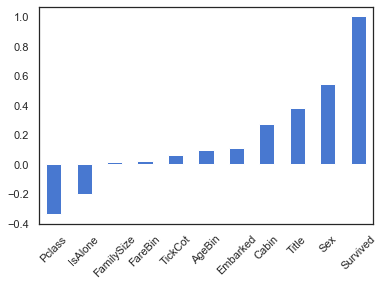

In [103]:
# 对one-hot编码数据进行相关性分析,由于特征值过多,仅显示影响最大的前10个特征
plt.figure()
data_code.corr()['Survived'].sort_values().plot.bar()
plt.xticks(rotation=45)